In [1]:
import os
from langchain import hub
from langchain.agents import create_openai_functions_agent
from langchain_openai.chat_models import AzureChatOpenAI
from langchain_community.utilities.polygon import PolygonAPIWrapper
from langchain_community.tools import PolygonLastQuote, PolygonTickerNews, PolygonFinancials, PolygonAggregates
import gradio as gr

import os, openai

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file

os.environ["LANGCHAIN_PROJECT"] = "langgraph-financial-agent"


llm  = AzureChatOpenAI(
    api_key=os.environ["AZURE_OPENAI_API_KEY"],
    azure_endpoint=os.environ["AZURE_OPENAI_ENDPOINT"],
    api_version=os.environ["AZURE_OPENAI_API_VERSION"],
    azure_deployment="gpt-4-32k",
    model="gpt-4-32k",
    streaming=True,
    temperature=0
)

c:\Users\shchitt\AppData\Local\anaconda3\envs\langgraph\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
prompt = hub.pull("hwchase17/openai-functions-agent")
prompt.pretty_print()

================================ System Message ================================

You are a helpful assistant

============================= Messages Placeholder =============================

{chat_history}

================================ Human Message =================================

{input}

============================= Messages Placeholder =============================

{agent_scratchpad}


## Tools and Agent

In [3]:
polygon = PolygonAPIWrapper()
tools = [
    PolygonLastQuote(api_wrapper=polygon),
    PolygonTickerNews(api_wrapper=polygon),
    PolygonFinancials(api_wrapper=polygon),
    PolygonAggregates(api_wrapper=polygon)
]

In [4]:
from langchain_core.runnables import RunnablePassthrough
from langchain_core.agents import AgentFinish

# Define the agent
agent_runnable = create_openai_functions_agent(llm, tools, prompt)
agent = RunnablePassthrough.assign(
    agent_outcome = agent_runnable
)

## Graph

In [5]:
# Define the function to execute tools
def execute_tools(data):
    agent_action = data.pop('agent_outcome')
    tool_to_use = {t.name: t for t in tools}[agent_action.tool]
    observation = tool_to_use.invoke(agent_action.tool_input)
    data['intermediate_steps'].append((agent_action, observation))
    return data

# Define logic that will be used to determine which conditional edge to go down
def should_continue(data):
    if isinstance(data['agent_outcome'], AgentFinish):
        return "exit"
    else:
        return "continue"

In [6]:
from langgraph.graph import END, Graph

workflow = Graph()
workflow.add_node("agent", agent)
workflow.add_node("tools", execute_tools)
workflow.set_entry_point("agent")
workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "continue": "tools",
        "exit": END
    }
)
workflow.add_edge('tools', 'agent')
app = workflow.compile()

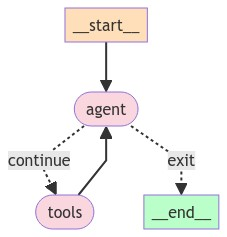

In [8]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass

In [9]:
result = app.invoke({"input": "Give me the top news about SBUX stock?", "intermediate_steps": []})
print(result)

{'input': 'Give me the top news about SBUX stock?', 'intermediate_steps': [(AgentActionMessageLog(tool='polygon_ticker_news', tool_input={'query': 'SBUX'}, log="\nInvoking: `polygon_ticker_news` with `{'query': 'SBUX'}`\n\n\n", message_log=[AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{\n  "query": "SBUX"\n}', 'name': 'polygon_ticker_news'}}, response_metadata={'finish_reason': 'function_call'}, id='run-f7129629-921a-40cd-9b0d-2cfbb5ec1464-0')]), '[{"id": "jZVPfW2a9xKl_2V4fT38AGTlNE53WR7EKg_PS7O8J-8", "publisher": {"name": "The Motley Fool", "homepage_url": "https://www.fool.com/", "logo_url": "https://s3.polygon.io/public/assets/news/logos/themotleyfool.svg", "favicon_url": "https://s3.polygon.io/public/assets/news/favicons/themotleyfool.ico"}, "title": "Is It Time to Sell Starbucks Stock?", "author": "newsfeedback@fool.com (Johnny Rice)", "published_utc": "2024-06-02T13:57:00Z", "article_url": "https://www.fool.com/investing/2024/06/02/is-it-time-to-sell-s

In [17]:
output = result['agent_outcome'].return_values["output"]
print(output)

Here are the top news about Starbucks (SBUX) stock:

1. [Is It Time to Sell Starbucks Stock?](https://www.fool.com/investing/2024/06/02/is-it-time-to-sell-starbucks-stock/) - Published by The Motley Fool, this article discusses the latest earnings release of Starbucks which wasn't good.

2. [1 No-Brainer Stock to Buy With $100 Right Now](https://www.fool.com/investing/2024/06/01/1-no-brainer-stock-to-buy-with-100-right-now/) - Another article from The Motley Fool suggests that despite current struggles, Starbucks should do well over the long term.

3. [4 Unforgettable Growth Stocks You'll Regret Not Buying in the New Nasdaq Bull Market](https://www.fool.com/investing/2024/06/01/nasdaq-bull-market-4-growth-stocks-regret-not-buy/) - This article lists Starbucks as one of the growth stocks to consider buying in the new Nasdaq bull market.

4. [Best Dividend Stocks: Starbucks vs. McDonald's](https://www.fool.com/investing/2024/06/01/best-dividend-stocks-starbucks-vs-mcdonalds/) - The Motle

In [ ]:
def financial_agent(input_text):
    result = app.invoke({"input": input_text, "intermediate_steps": []})
    output = result['agent_outcome'].return_values["output"]
    return output

In [19]:
output = financial_agent("How are the financials of SNOW stock? Good or bad?")
print(output)

The financials of Snowflake Inc. (SNOW) can be summarized as follows:

- The company's total assets amount to $7,722,322,000.
- The total liabilities are $2,253,707,000.
- The company's equity is $5,463,615,000.
- The company's net income/loss is -$797,526,000.
- The company's revenues are $2,065,659,000.
- The company's operating expenses are $2,190,386,000.
- The company's operating income/loss is -$842,267,000.
- The company's net cash flow from operating activities is $545,639,000.
- The company's net cash flow from investing activities is -$597,885,000.
- The company's net cash flow from financing activities is -$92,624,000.

In summary, Snowflake Inc. has a significant amount of assets and equity, but it is currently operating at a loss and has a negative net income. The company is spending more than it is earning, which is not uncommon for growth-oriented tech companies. However, this could be a concern if the trend continues over the long term.


## Gradio Interface

In [18]:
ui = gr.Interface(
    fn=financial_agent,
    inputs=gr.Textbox(lines=2, placeholder="Enter your query here..."),
    outputs=gr.Markdown(),
    title="Financial Agent",
    description="Financial Data Explorer: Leveraging Advanced API Tools for Market Insights"
)

ui.launch()

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.
